- 参考
    - https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html

In [2]:
import subprocess
import os
os.environ['CURL_CA_BUNDLE'] = ''

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

## Outline

- 数据并行是切数据（scattering inputs and gathering outputs），模型并行是切模型（shards）
    - 模型并行：单卡放不下一份模型
    - 将一份大模型，不同的层切分到不同的卡上
- device_map：Huggingface 提供的参数
- 模型并行 on ToyModel
- 模型并行 on ResNet
    - 不需要引入额外的 torch api 支持

## Huggingface 的支持

### device_map

可选项："auto", "balanced", "balanced_low_0", "sequential"

`auto`：GPU(s) > CPU (RAM) > Disk

In [3]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    load_in_8bit=True,
    device_map="auto",
)
for i, para in enumerate(model.named_parameters()):
    # print(f'{i}, {para[0]}\t {para[1].device} \t{para[1].dtype}')
    print(f'{i}, \t {para[1].device} \t{para[1].dtype}')

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

0, 	 cuda:0 	torch.float16
1, 	 cuda:0 	torch.int8
2, 	 cuda:0 	torch.int8
3, 	 cuda:0 	torch.int8
4, 	 cuda:0 	torch.int8
5, 	 cuda:0 	torch.int8
6, 	 cuda:0 	torch.int8
7, 	 cuda:0 	torch.int8
8, 	 cuda:0 	torch.float16
9, 	 cuda:0 	torch.float16
10, 	 cuda:0 	torch.int8
11, 	 cuda:0 	torch.int8
12, 	 cuda:0 	torch.int8
13, 	 cuda:0 	torch.int8
14, 	 cuda:0 	torch.int8
15, 	 cuda:0 	torch.int8
16, 	 cuda:0 	torch.int8
17, 	 cuda:0 	torch.float16
18, 	 cuda:0 	torch.float16
19, 	 cuda:0 	torch.int8
20, 	 cuda:0 	torch.int8
21, 	 cuda:0 	torch.int8
22, 	 cuda:0 	torch.int8
23, 	 cuda:0 	torch.int8
24, 	 cuda:0 	torch.int8
25, 	 cuda:0 	torch.int8
26, 	 cuda:0 	torch.float16
27, 	 cuda:0 	torch.float16
28, 	 cuda:0 	torch.int8
29, 	 cuda:0 	torch.int8
30, 	 cuda:0 	torch.int8
31, 	 cuda:0 	torch.int8
32, 	 cuda:0 	torch.int8
33, 	 cuda:0 	torch.int8
34, 	 cuda:0 	torch.int8
35, 	 cuda:0 	torch.float16
36, 	 cuda:0 	torch.float16
37, 	 cuda:0 	torch.int8
38, 	 cuda:0 	torch.int8
39, 	 cu

## Toy example

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10000, 1000).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(1000, 5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))

In [3]:
# watch -n 1 nvidia-smi
model = ToyModel()

In [5]:
model

ToyModel(
  (net1): Linear(in_features=10000, out_features=1000, bias=True)
  (relu): ReLU()
  (net2): Linear(in_features=1000, out_features=5, bias=True)
)

In [6]:
type(list(model.net1.parameters())[0])

torch.nn.parameter.Parameter

In [7]:
print(next(model.net1.parameters()).device)
print(next(model.net2.parameters()).device)

cuda:0
cuda:1


In [8]:
# 单次 forward 和 back-propagation 示例
model = ToyModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

optimizer.zero_grad()
outputs = model(torch.randn(20, 10000))
labels = torch.randn(20, 5).to('cuda:1')
loss_fn(outputs, labels).backward()
optimizer.step()

## Split ResNet

- 简单介绍下 ResNet

```
model = ResNet(block, layers, **kwargs)

# resnet18
_resnet(BasicBlock, [2, 2, 2, 2])
# resnet34
_resnet(BasicBlock, [3, 4, 6, 3])

# resnet50
_resnet(Bottleneck, [3, 4, 6, 3])
# resnet101
_resnet(Bottleneck, [3, 4, 23, 3])
# resnet152
_resnet(Bottleneck, [3, 8, 36, 3])
```

In [9]:
import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck
# from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152

In [10]:
# resnet50
model = ResNet(Bottleneck, [3, 4, 6, 3])

In [11]:
# conv1 => bn1 => relu => maxpool => layer1-layer4 => avgpool => fc
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
from torchsummary import summary

In [14]:
summary(model, input_size=(3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

### 自定义模型并行

In [20]:
# 测试 view 函数的功能
t = torch.rand((2, 3, 4))
print(t.shape)
t.view(t.size(0), -1).shape

torch.Size([2, 3, 4])


torch.Size([2, 12])

In [16]:
class ModelParallelResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
        # conv1 => bn1 => relu => maxpool => layer1-layer4 => avgpool => fc
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1, 
            self.layer2
        ).to('cuda:0')
        
        self.seq2 = nn.Sequential(
            self.layer3, 
            self.layer4,
            self.avgpool,
        ).to('cuda:1')
        
        self.fc.to('cuda:1')
    
    def forward(self, x):
        # model parts（layers） 的（卡间）串行
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

In [17]:
def model_size(model):
    return sum([para.numel() for para in model.parameters()])

In [18]:
model_size(ResNet(Bottleneck, [3, 4, 6, 3]))

25557032

In [19]:
model_size(ModelParallelResNet50())

25557032

## Train pipeline

In [21]:
# 测试生成 one-hot 标签
num_classes = 10

one_hot_indices = torch.LongTensor(5).random_(0, num_classes).view(5, 1)
print(one_hot_indices)

labels = torch.zeros(5, num_classes).scatter_(1, one_hot_indices, 1)
print(labels)

tensor([[9],
        [8],
        [1],
        [0],
        [6]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


In [22]:
num_classes = 1000
num_batches = 3
batch_size = 120
image_w = 128
image_h = 128


def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # 生成 one-hot 标签
    one_hot_indices = torch.LongTensor(batch_size) \
                           .random_(0, num_classes) \
                           .view(batch_size, 1)

    for _ in range(num_batches):
        # generate random inputs and labels
        # (b, c, w, h)
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        # one hot：(batch_size, num_classes)，行粒度只有一个为1 （one-hot）
        # scatter 的三个参数：dim, index, src
        labels = torch.zeros(batch_size, num_classes) \
                      .scatter_(1, one_hot_indices, 1)

        # run forward pass
        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))
        # print('outputs', outputs.shape)
        # run backward pass
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

In [23]:
import numpy as np
import timeit

num_repeat = 10
stmt = "train(model)"

# 模型并行（多卡）
setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

# 单卡
setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)

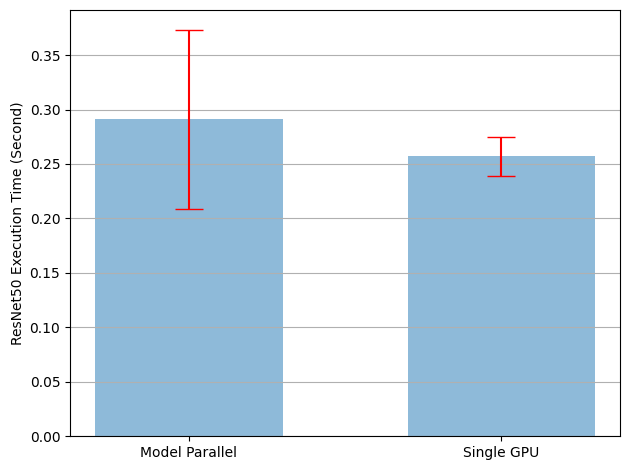

In [24]:
import matplotlib.pyplot as plt
# plt.switch_backend('Agg')

def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
#     plt.savefig(fig_name)
#     plt.close(fig)

plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

In [25]:
mp_mean, rn_mean

(0.29085834696888924, 0.2570463016629219)

In [26]:
(mp_mean - rn_mean) / rn_mean

0.13154067997565203